In [ ]:
%pip install qiskit
%pip install pylatexenc

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Qubit
from qiskit.quantum_info import Statevector, Operator

from qiskit.circuit.library.standard_gates import HGate

import matplotlib.pyplot as plt

import numpy as np

#Multi-Controlled Gate

Given an array of qubits (controls) and a quantum gate (U) returns the controlled version of U.

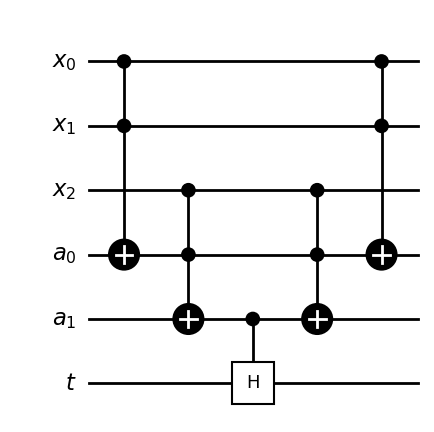

In [ ]:
def MultiControlledGate(n ,U):
  control_register = QuantumRegister(size=n, name="x")
  ancilla_register = AncillaRegister(size=n-1, name="a")
  target_register = QuantumRegister(size=1, name="t")

  #prepares a subroutine which stores the conjunction of all the x[i]s in a[n-2]
  setup = QuantumCircuit(control_register, ancilla_register, name="setup")
  setup.ccx(control_register[0], control_register[1], ancilla_register[0])
  for i in range(2, n):
    setup.ccx(control_register[i], ancilla_register[i-2], ancilla_register[i-1])

  final = QuantumCircuit(control_register, ancilla_register, target_register, name="multicontrolledU")
  final.compose(setup, inplace=True)
  final.append(U.control(1), [ancilla_register[n-2], target_register[0]])
  final.compose(setup.inverse(), inplace=True)

  return final

MultiControlledGate(3,HGate()).draw(output="mpl", style="bw")

This method is useful because the number of gates used is linear in the number of control qubits. The downside is that the number of ancilla qubits used is also linear in the number of control qubits.

Below we give another implementation, in which the number of gates is still linear in the number of control qubits, but now now only two ancilla qubits are used.

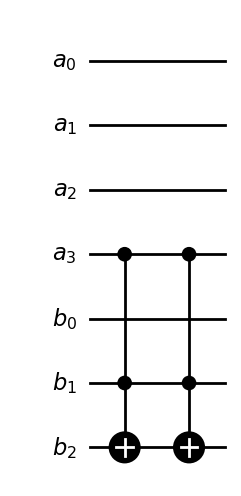

In [ ]:
def Flip_Base():
  a_register = QuantumRegister(size=2, name = "a")
  b_register = QuantumRegister(size=1, name = "b")
  F = QuantumCircuit(a_register, b_register)
  F.ccx(a_register[0], a_register[1], b_register[0])
  return F

def Flip(n):
  if n == 2:
    return Flip_Base()
  a_register = QuantumRegister(size=n, name = "a")
  b_register = QuantumRegister(size=n-1, name = "b")
  F = QuantumCircuit(a_register, b_register)
  F.ccx(a_register[n-1], b_register[n-3], b_register[n-2])
  F.compose(Flip(n-1))
  F.ccx(a_register[n-1], b_register[n-3], b_register[n-2])
  return F

Flip(4).draw(output="mpl", style="bw")